# 製作混合圖形

### 起手式

In [1]:
from PIL import Image
import cv2
import numpy as np
from io import BytesIO
def to_pil(ima):
    if ima.dtype == np.float64:
        ima = (ima*255).clip(0,255).astype('uint8')
    return Image.fromarray(ima)
    
def img_to_png(ima, cvt=None):
    if cvt:
        ima = cv2.cvtColor(ima, cvt)
    im = to_pil(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    return bio.getvalue()

### 夢露的照片 (public domain) 


shape of the png image: (580, 572, 3)
shape of the grayscale image: (580, 572)


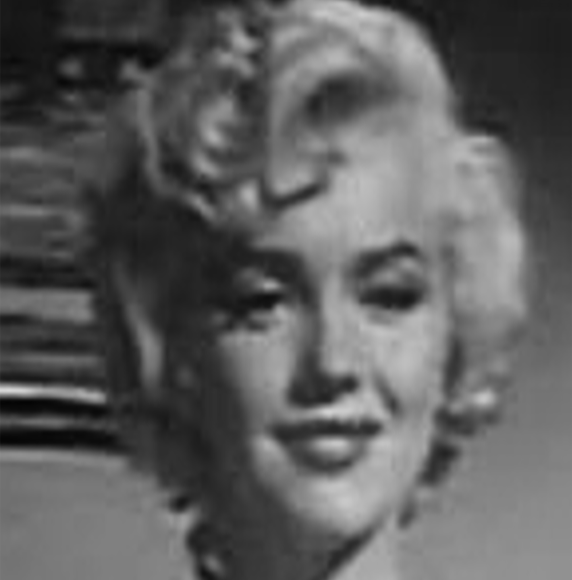

In [2]:
m_crop = cv2.imread("img/m_crop.png")
m_crop = cv2.resize(m_crop, (m_crop.shape[1]//2, m_crop.shape[0]//2))
print("shape of the png image:", m_crop.shape)
m_crop = m_crop[:, :, 0]
print("shape of the grayscale image:", m_crop.shape)
Image.fromarray(m_crop)

### 愛因斯坦 (public domain photo)

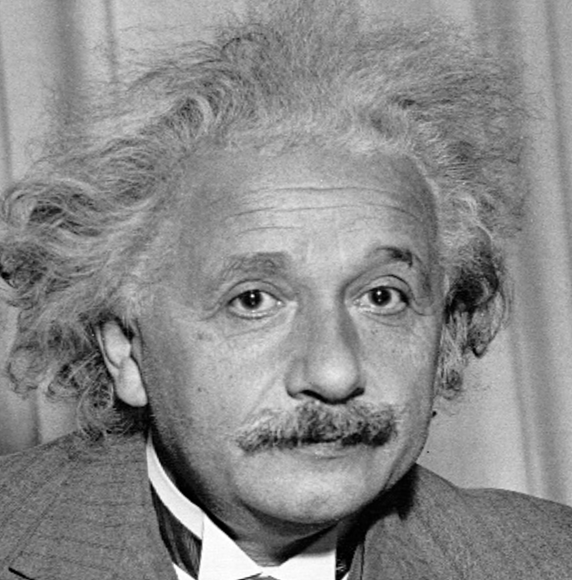

In [3]:
e_crop = cv2.imread("img/e_crop.png")[:, :, 0]
e_crop = cv2.resize(e_crop, (e_crop.shape[1]//2, e_crop.shape[0]//2))
Image.fromarray(e_crop)

## 2D Gaussian filter

The 2D Gaussian kernel is defined as
$$g(x,y) = \frac{1}{2\pi \sigma^2} \cdot e^{-\frac{x^2 + y^2}{2 \sigma^2}}.$$
and a Gaussian filter (or Gaussian blur) is just a convolution $*$ with a Gaussian kernel.

We can use the convolution theorem 
$$f*g= \mathcal{F}^{-1}\big\{\mathcal{F}\{f\}\cdot\mathcal{F}\{g\}\big\} $$
and FFT to implement the gaussian filter

In [5]:
# In case you don't have scipy installed
# you can use our home made gaussian_filter
# see also https://gist.github.com/thearn/5424195 http://subsurfwiki.org/wiki/Gaussian_filter
# 下面是實做
from numpy.fft import fft2, ifft2
from numpy import exp, pi

def my_gaussian_filter(img, sigma):
    "build the 'rolled' gaussion kernel, so that [0,0] is really (0,0)"
    # technical part, mostly setting up the range of spatial domain
    cx, cy = img.shape[0]//2, img.shape[1]//2        # center positions
    x1 = np.roll(np.arange(-cx, cx), cx)             # rolled x cordinate
    y1 = np.roll(np.arange(-cy, cy), cy)             # rolled y cordinate
    x, y = np.meshgrid(y1, x1)                       # rolled grid
    # Math part
    g = exp(-(x**2+y**2)/2/sigma**2)/(2*pi*sigma**2) # and finally, the gaussian filter
    return np.real(ifft2(fft2(img)*fft2(g)))         # convolution

gaussian_filter = my_gaussian_filter

# 不過我們直接用寫好的
# if you have scipy installed, you can use it.
from scipy.ndimage.filters import gaussian_filter

### Remark

```python
>>> x = np.arange(10)
>>> x
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
>>> np.roll(x, 2)
array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])
```

### 夢露照片中的低頻部份（模糊部份）

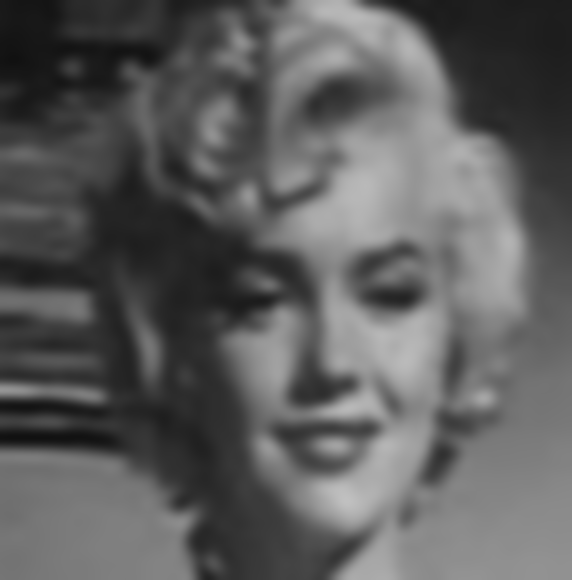

In [6]:
m_blur = gaussian_filter(m_crop/255, 5)
to_pil(m_blur)

### 愛因斯坦的低頻部份

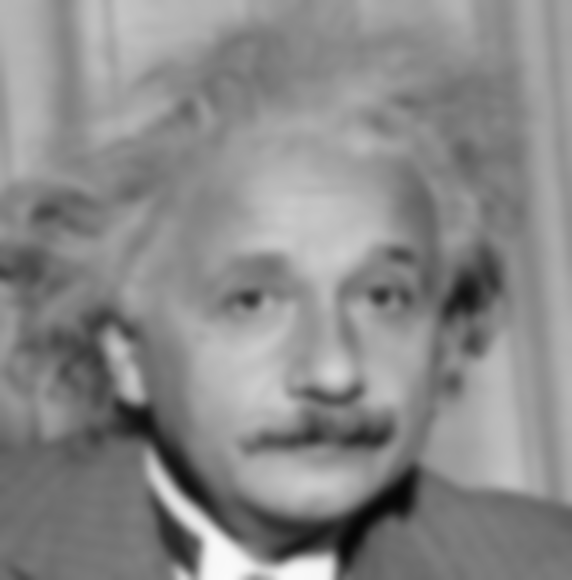

In [7]:
e_blur = gaussian_filter(e_crop/255, 5)
to_pil(e_blur)

### 原圖扣掉低頻部份，就是高頻部份（邊界）

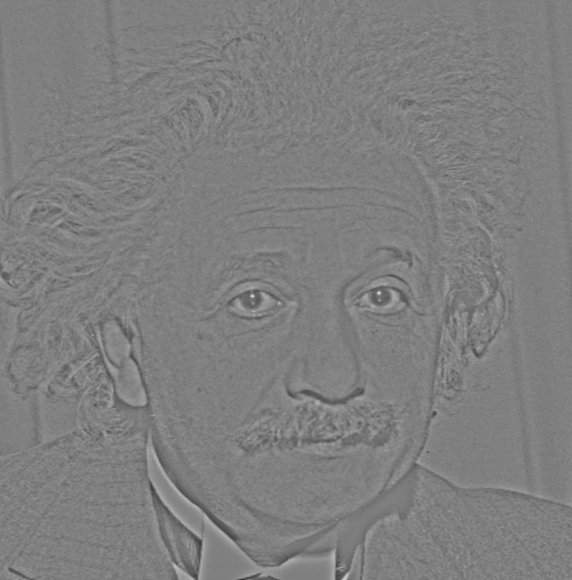

In [8]:
e_highpass = (e_crop/255 - e_blur)/2+0.5
to_pil(e_highpass)

### 愛因斯坦的高頻加上夢露的低頻，就成了混合圖了

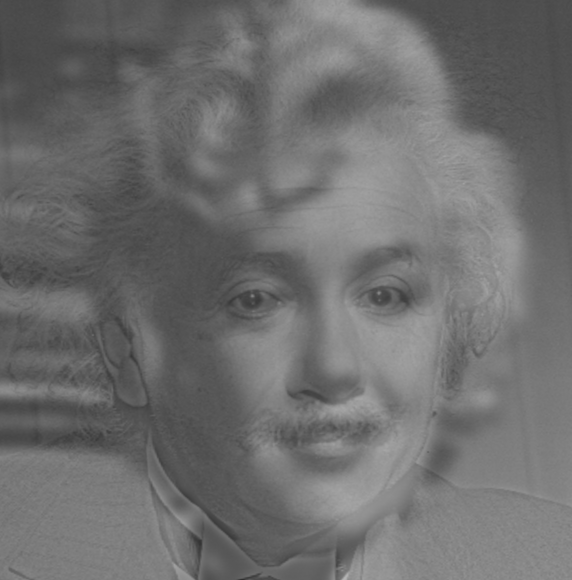

In [9]:
to_pil( e_highpass*0.5 + m_blur*0.5) 

### 可以動手調整看看看

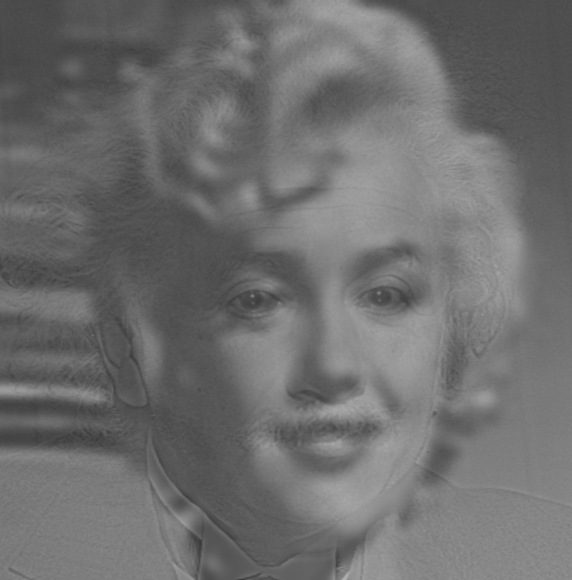

In [10]:
from ipywidgets import interact
import ipywidgets as widgets
@interact(sigma=widgets.FloatSlider(min=1, max=30, step=1, value=3),
         lowpass_weight=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05))
def hybrid(sigma=5, lowpass_weight=0.5):
    m_blur = gaussian_filter(m_crop/255, sigma)
    e_blur = gaussian_filter(e_crop/255, sigma)
    e_highpass = (e_crop/255 - e_blur)/2+0.5
    return to_pil(m_blur*lowpass_weight + e_highpass*(1-lowpass_weight))                  